In [1]:
import gzip
import random
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

In [2]:
def readGz(path):
    for l in gzip.open(path, 'rt'):
        yield eval(l)

def readCSV(path):
    f = gzip.open(path, 'rt')
    f.readline()
    for l in f:
        yield l.strip().split(',')

In [3]:
example = readCSV("train_Interactions.csv.gz")
print(next(example))
del example

['u79354815', 'b14275065', '4']


In [4]:
### Would-read baseline: just rank which books are 
### popular and which are not, and return '1' if a
### book is among the top-ranked
train_size = 190000
val_size   = 10000

data = [line for line in readCSV("train_Interactions.csv.gz")]
train = data[:train_size]
val   = data[train_size:]
print(len(data))
print(len(train))
print(len(val))

200000
190000
10000


In [5]:
booksReadBy = defaultdict(set)
train_booksReadBy = defaultdict(set)
val_booksReadBy = defaultdict(set)
usersReadBook = defaultdict(set)
val_usersReadBook = defaultdict(set)
train_usersReadBook = defaultdict(set)
all_books = set()
val_all_books = set()
train_all_books = set()
    
for user, book, _ in data:
    all_books.add(book)
    usersReadBook[book].add(user)
    booksReadBy[user].add(book)

for user, book, _ in train:
    train_all_books.add(book)
    train_usersReadBook[book].add(user)
    train_booksReadBy[user].add(book)

for user, book, _ in val:
    val_all_books.add(book)
    val_usersReadBook[book].add(user)
    val_booksReadBy[user].add(book)

val_unread = []
all_books_count = len(all_books)
for user, book, _ in val: 
    unread_book = random.sample(all_books, 1)
    while(unread_book in list(booksReadBy[user])):
        unread_book = random.sample(all_books, 1)
    val_unread.append([user, str(unread_book[0]), '-1'])

val = val + val_unread
print(len(val))
print(val[0:3])

20000
[['u35176258', 'b30592470', '3'], ['u30851063', 'b81941226', '3'], ['u31368414', 'b40097012', '5']]


In [6]:
bookCount = defaultdict(int)
total_books_read = 0

for user, book, _ in train:
    bookCount[book]  += 1
    total_books_read += 1

mostPopular = [(bookCount[book], book) for book in bookCount]
mostPopular.sort()
mostPopular.reverse()

In [7]:
def popular_books_set(mostPopular, threshold_ratio):
    return1 = set()
    cur_book_count = 0
    for book_count, book in mostPopular:
        cur_book_count += book_count
        return1.add(book)
        if cur_book_count > total_books_read *\
        threshold_ratio: 
            break
    return return1

In [8]:
def jaccard(set1, set2):
    """
    Returns the Jaccard similarity between two sets,
    set1 & set2
    """
    set_intersection = len(set1.intersection(set2))
    set_union = len(set1.union(set2))
    if set_union == 0:
        return 0
    else:
        return set_intersection / set_union

In [9]:
def jaccard_prediction(jac_sims):
    """
    Returns the Jaccard similarity between two sets,
    set1 & set2
    """
    prediction = False
    if jac_sims != []:
        prediction = max(jac_sims) >= jaccard_threshold
    return prediction

# Question 4

In [10]:
sizes = 10
pops = np.linspace(0.2, 0.7, sizes)
jaccards = np.linspace(0.01, 0.1, sizes)
print(len(pops))
print(len(jaccards))

10
10


In [11]:
def calc_jac(user, book_predict):
    books_user_read = train_booksReadBy[user]
    jac_sims = []
    for users_book in books_user_read:   
        users_read_book_predict = train_usersReadBook[book_predict]
        users_read_users_book = train_usersReadBook[users_book]
        jac_sim = jaccard(users_read_book_predict, users_read_users_book)
        jac_sims.append(jac_sim)
    return jac_sims

In [12]:
def calc_jac_train(user, book_predict):
    books_user_read = train_booksReadBy[user]
    jac_sims = []
    for users_book in books_user_read:  
        if users_book == book_predict: continue
        users_read_book_predict = train_usersReadBook[book_predict]
        users_read_users_book = train_usersReadBook[users_book]
        jac_sim = jaccard(users_read_book_predict, users_read_users_book)
        jac_sims.append(jac_sim)
    return jac_sims

In [13]:
train_LR = train
train_unread = []

for user, book, _ in train: 
    unread_book = random.sample(all_books, 1)
    while(unread_book in list(booksReadBy[user])):
        unread_book = random.sample(all_books, 1)
    train_unread.append([user, str(unread_book[0]), '-1'])

In [14]:
def feature(datum, func):
    user, book, _ = datum
    jac_sims = func(user, book)
    if jac_sims == []: jac_val = 0
    else: jac_val = max(jac_sims)
    pop_val = book in return1
    feat = [1]
    feat.append(pop_val)
    feat.append(jac_val)
    return feat

In [15]:
return1 = popular_books_set(mostPopular, 0.64)
train_LR = train + train_unread
LR_feat_train   = np.array([feature(d, calc_jac_train) for d in train_LR])
LR_labels_train = [int(rating) >= 0 for _, _, rating in train_LR]
LR_feat_val  = np.array([feature(d, calc_jac) for d in val])
LR_labels_val = [int(rating) >= 0 for _, _, rating in val]

C_values = np.logspace(-2, 0, num = 40)
accs = []
loop_count = 0
for C_value in C_values:
    loop_count += 1
    if loop_count % 10 == 0: print(loop_count, end = ', ')
    clf = LogisticRegression(C = C_value).fit(LR_feat_train, LR_labels_train)
    acc = clf.score(LR_feat_val, LR_labels_val)
    accs.append(acc)

10, 20, 30, 40, 

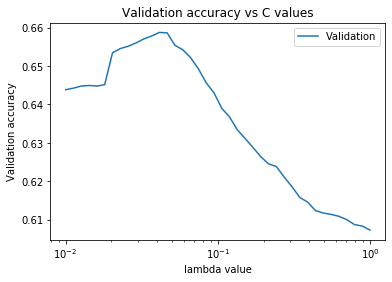


C value for highest accuracy is: 0.04124626382901352
Best validation accuracy is: 0.65875


In [16]:
plt.plot(C_values, accs, label='Validation')
plt.ylabel('Validation accuracy')
plt.xlabel('lambda value'), plt.xscale('log')
plt.title('Validation accuracy vs C values')
plt.legend()
plt.show()

indx = accs.index(max(accs))
print('\nC value for highest accuracy is:', C_values[indx])
print('Best validation accuracy is:', accs[indx])

In [29]:
def predict_datapoint_old(user, book_predict):
    books_user_read = booksReadBy[user]
    jac_sims = calc_jac(user, book_predict)
    prediction_jac = max(jac_sims) >= jaccard_threshold
    prediction_pop = book_predict in return1
    prediction = prediction_jac or prediction_pop          
    return prediction

In [30]:
clf = LogisticRegression(C = C_values[indx]).fit(LR_feat_train, LR_labels_train)
def predict_datapoint_new(user, book_predict):
    feat = np.array(feature((user, book_predict,_), calc_jac_train))
    prediction = clf.predict(feat)       
    return prediction

In [36]:
test_set = []
for l in open("pairs_Read.txt"):
    if l.startswith("userID"): # it's just the header
        continue
    user, book = l.strip().split('-') # it is a datapoint
    test_set.append((user, book, _))

X_test   = np.array([feature(d, calc_jac) for d in test_set])
y_test   = [int(rating) >= 0 for _, _, rating in test_set]
confidence_scores = clf.decision_function(X_test)

pos_count = sum(clf.predict(X_test))
print(pos_count)

slack = 0
conf_with_labels = zip(confidence_scores, [(d[0],d[1]) for d in test_set])
conf_with_labels = list(conf_with_labels)
conf_with_labels.sort(reverse = True)
positives = conf_with_labels[:pos_count + slack]
negatives = conf_with_labels[pos_count + slack:]
positives = [d[1] for d in positives]
negatives = [d[1] for d in negatives]

count = 0
with open("predictions_Read.txt", 'w') as predictions:
    for l in open("pairs_Read.txt"):
        if l.startswith("userID"): # it's just the header
            predictions.write(l)
            continue
        user, book = l.strip().split('-') # it is a datapoint
        if (user, book) in positives:
            count += 1
            predictions.write(user + '-' + book + ",1\n")
        else:
            predictions.write(user + '-' + book + ",0\n")
print(count)

8567
8567


In [34]:
# test_set = []
# with open("predictions_Read.txt", 'w') as predictions:
#     for l in open("pairs_Read.txt"):
#         if l.startswith("userID"): # it's just the header
#             predictions.write(l)
#             continue
#         user, book = l.strip().split('-') # it is a datapoint
#         test_set.append(user, book)
#         prediction = predict_datapoint_new(user, book)
#         if prediction:
#             predictions.write(user + '-' + book + ",1\n")
#         else:
#             predictions.write(user + '-' + book + ",0\n")